# Example of usage of Visual NLP Dicom Pretrained Pipelines
In this notebook we will be exploring three different pipelines for doing Dicom De-identification. The pipelines differ from each other according to the strategy they use to deal with the de-identification process.</br>

## Install spark-ocr python package
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar`
- or `secret` for Spark OCR
- `aws_access_key` and `aws_secret_key`for download pretrained models

For more details about Dicom de-identification please read:

 - [DICOM de-identification at scale in Visual NLP — Part 1.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-1-68784177f5f0)

 - [DICOM de-identification at scale in Visual NLP — Part 2.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-2-361af5e36412)

 - [DICOM de-identification at scale in Visual NLP — Part 3.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-3-61cecc3adb56)

In [1]:
license = ""
secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

## Initialization of spark session

In [2]:
from sparkocr import start
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

nlp_secret = ""


spark = start(secret=secret,
              jar_path=spark_ocr_jar_path, nlp_internal="5.5.0", nlp_secret=nlp_secret)

spark

Spark version: 3.4.1
Spark NLP version: 5.5.2
Spark NLP for Healthcare version: 5.5.0
Spark OCR version: 5.5.0



## Import Spark OCR transformers

In [3]:
import pandas as pd

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *
import pyspark.sql.functions as f

from pyspark.ml import PipelineModel, Pipeline

## First we analyze the metadata

In [4]:
dicom = DicomToMetadata() \
    .setInputCol("content") \
    .setOutputCol("metadata")

## Read dicom objects as binary file and display metadata
We will be using a sample DICOM file for this, let's first visualize the images and metadata.


In [9]:
import pkg_resources
dicom_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/dicoms/deidentify-medical-1.dcm')
dicom_df = spark.read.format("binaryFile").load(dicom_path)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Show original DICOM

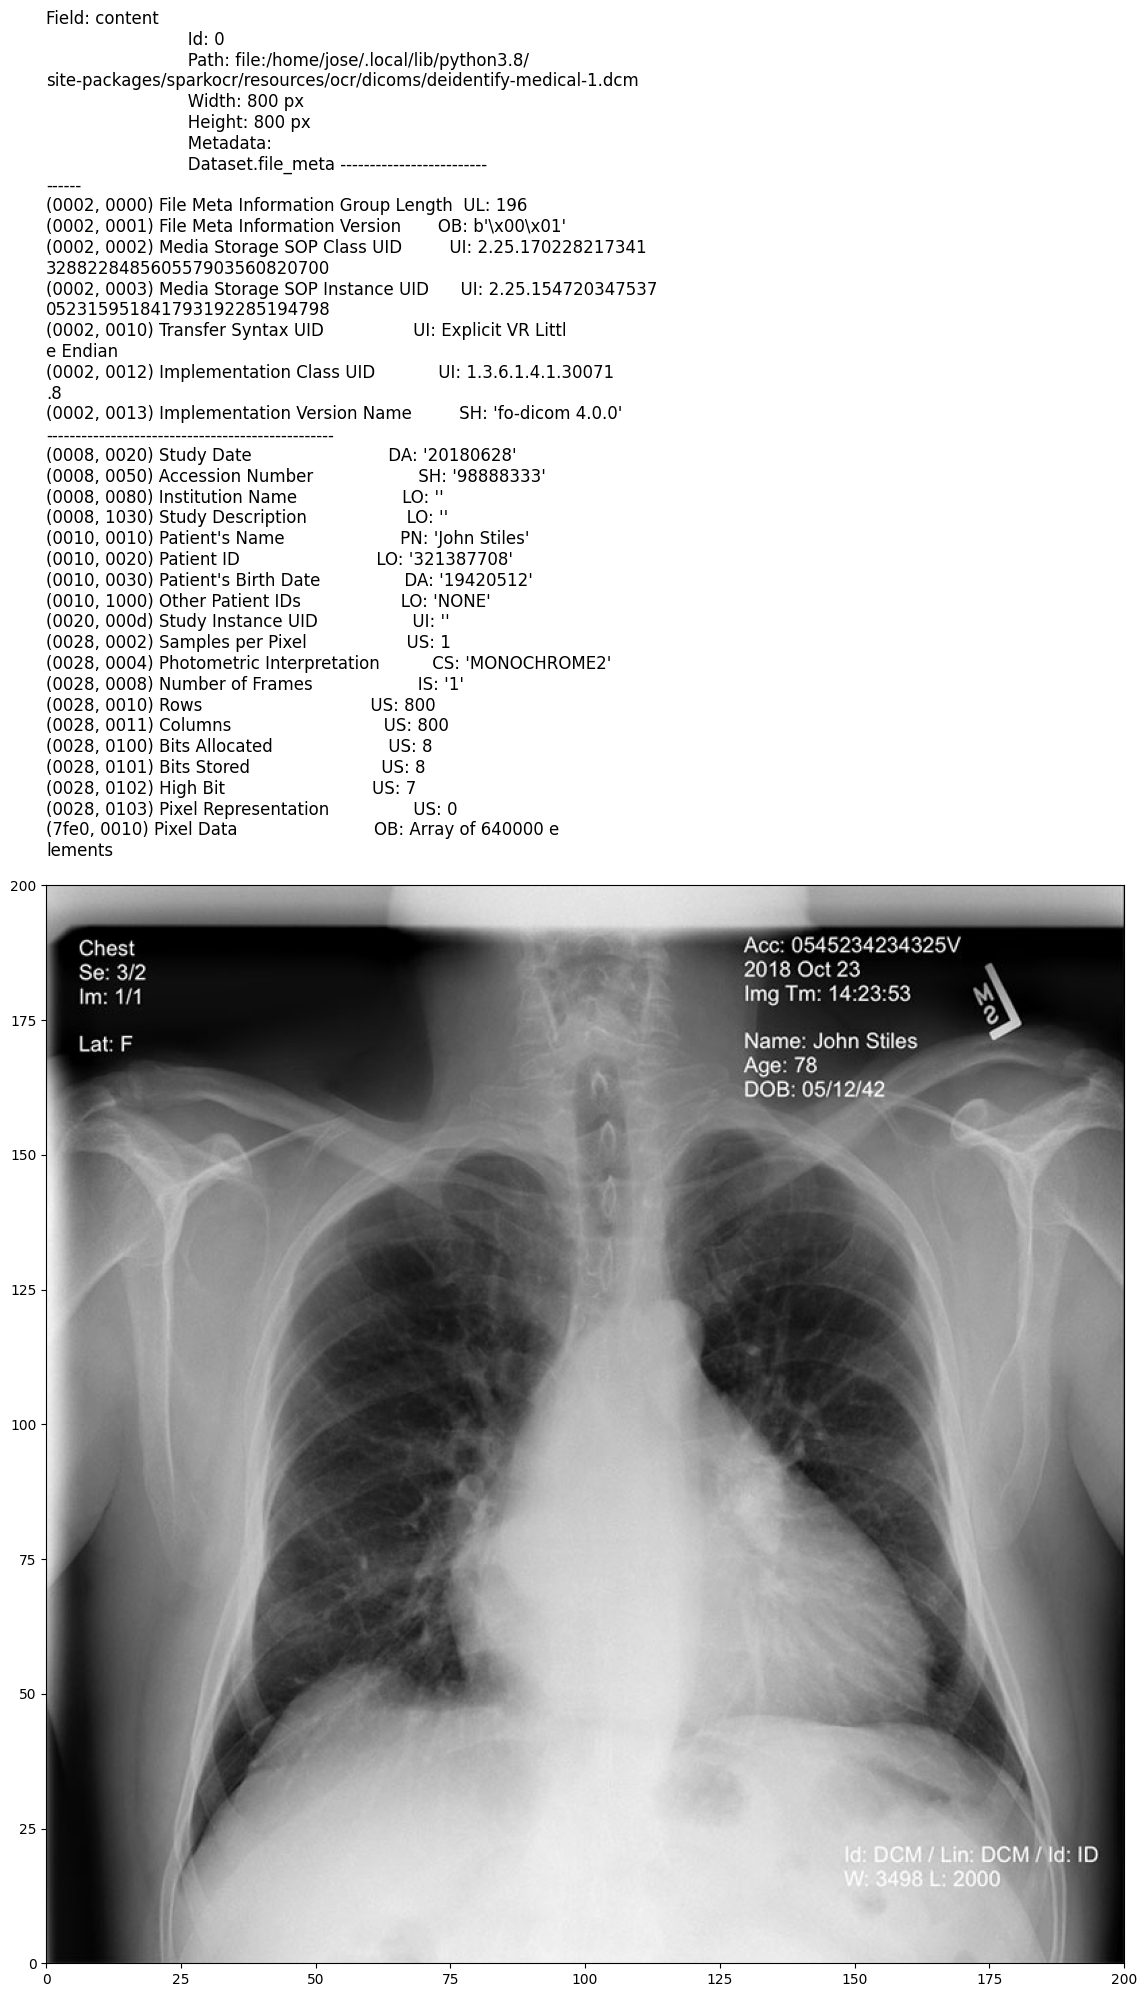

In [19]:
display_dicom(dicom_df, "content")

## Let's read the metadata into a Spark Dataframe
'metadata' column will contain it as a string

In [14]:
result = dicom.transform(dicom_df).cache()
print(result.select("metadata").collect()[0].metadata)

{
    "StudyDate": "20180628",
    "AccessionNumber": "98888333",
    "InstitutionName": "",
    "StudyDescription": "",
    "Patient'sName": "John Stiles",
    "PatientID": "321387708",
    "Patient'sBirthDate": "19420512",
    "OtherPatientIDs": "NONE",
    "StudyInstanceUID": "",
    "SamplesperPixel": "1",
    "PhotometricInterpretation": "MONOCHROME2",
    "NumberofFrames": "1",
    "Rows": "800",
    "Columns": "800",
    "BitsAllocated": "8",
    "BitsStored": "8",
    "HighBit": "7",
    "PixelRepresentation": "0"
}


## Pretrained Pipeline #1: `dicom_deid_generic_augmented_minimal`
This pipeline will attempt to remove the least possible amount of tags and image texts.

In [5]:
from sparkocr.pretrained import PretrainedPipeline
pipeline = PretrainedPipeline("dicom_deid_generic_augmented_minimal", 'en', 'clinical/ocr')

dicom_deid_generic_augmented_minimal download started this may take some time.
Approx size to download 1.7 GB
[OK!]


In [10]:
result = pipeline.transform(dicom_df).cache()

/home/jose/.local/lib/python3.8/site-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


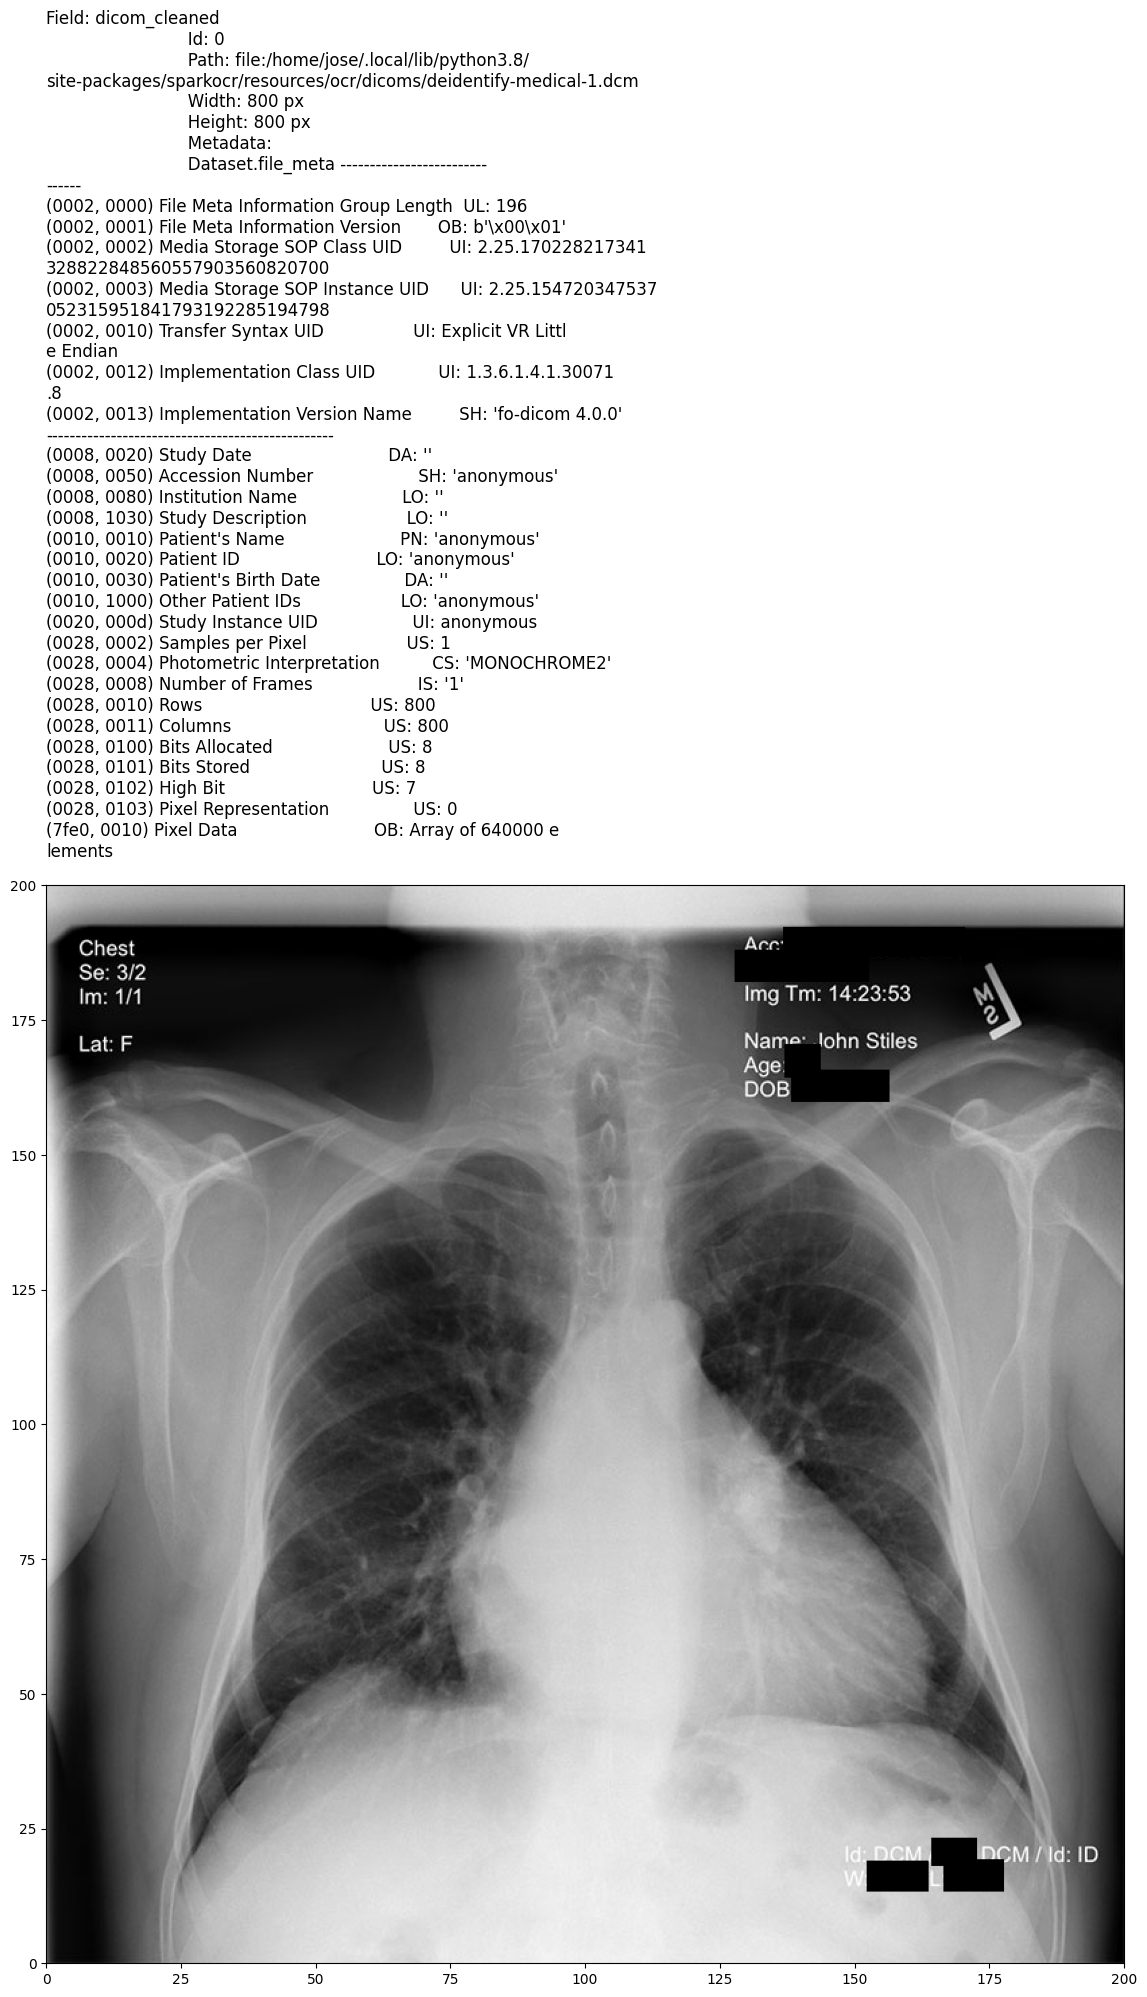

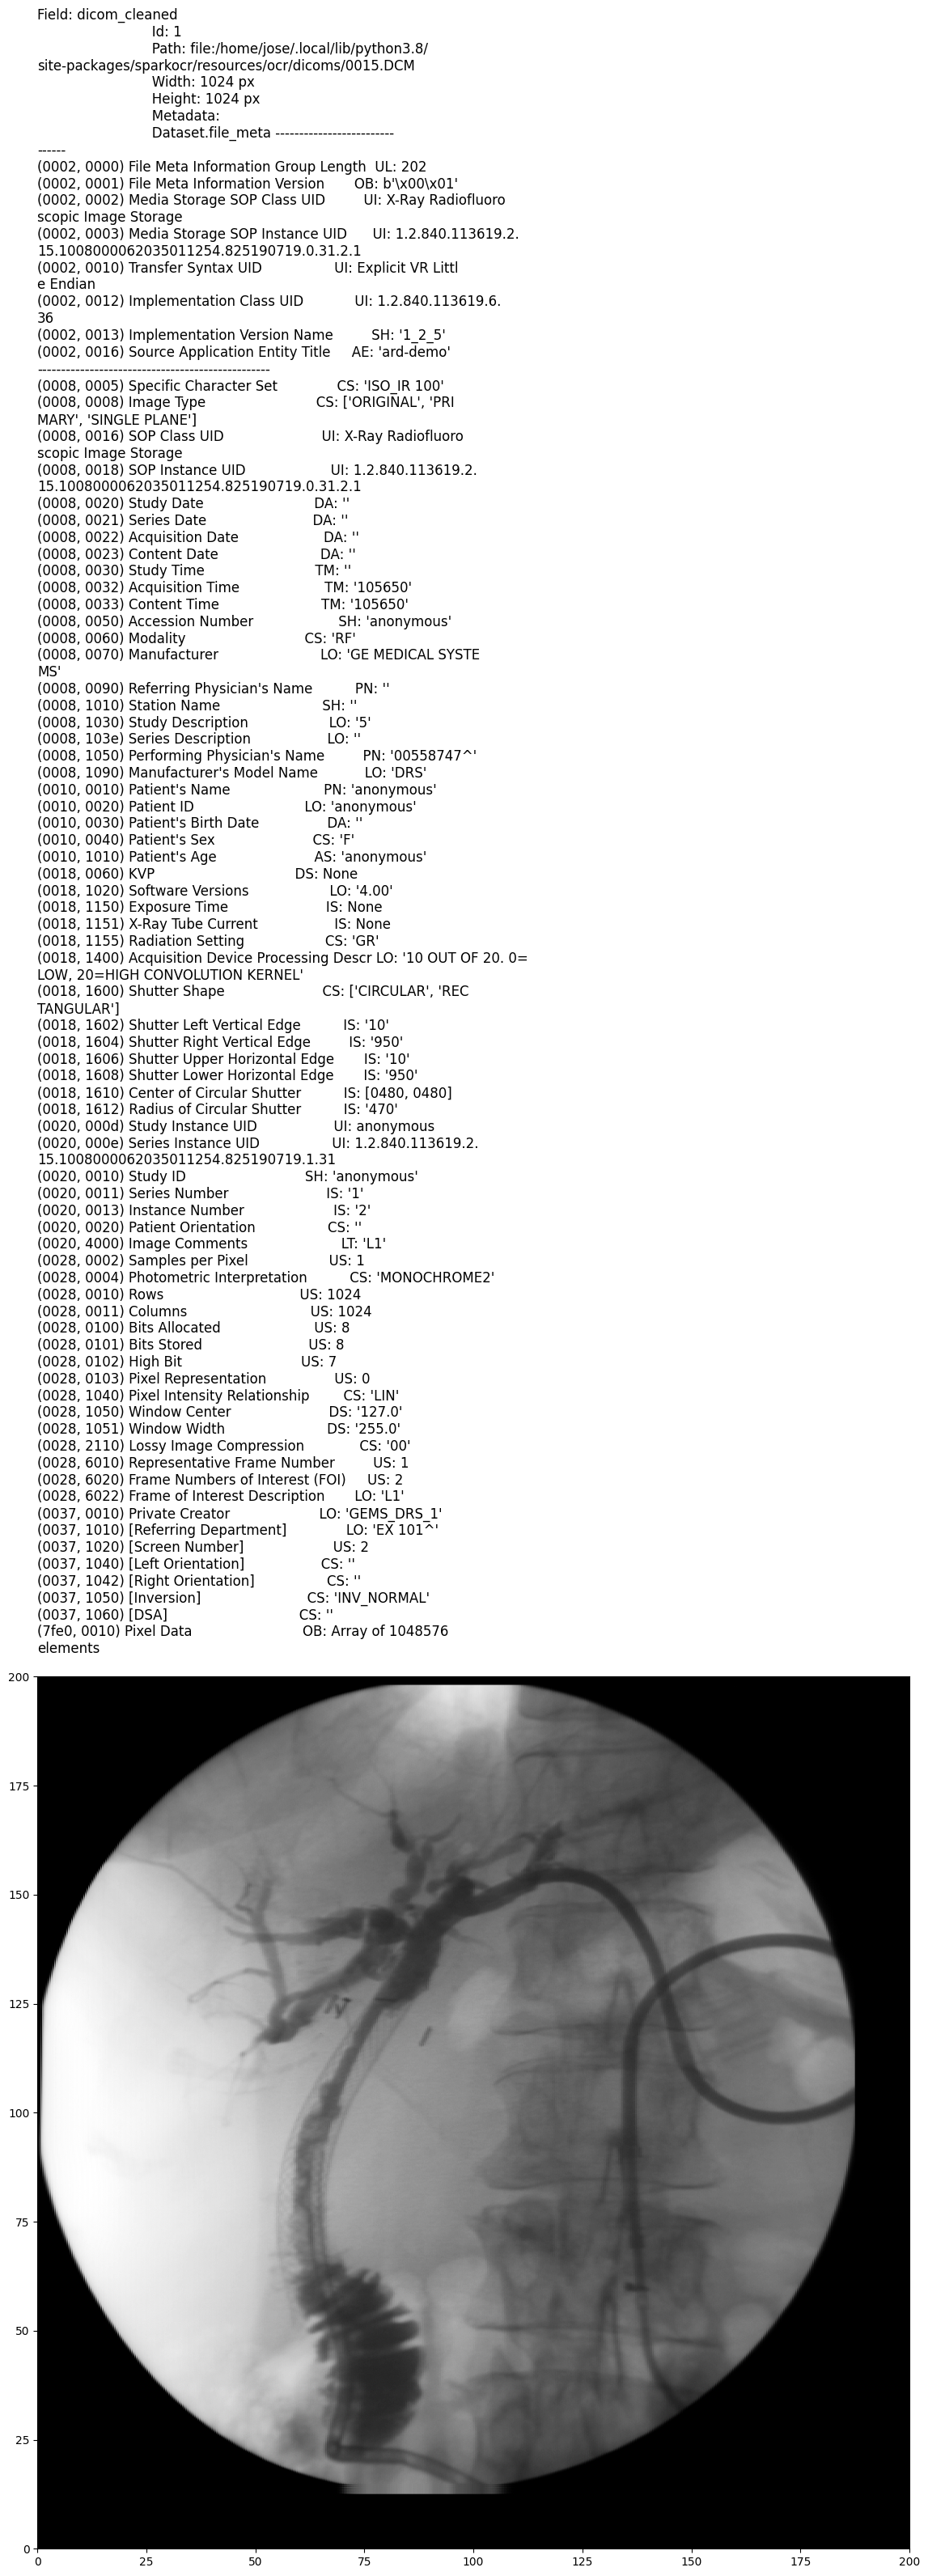

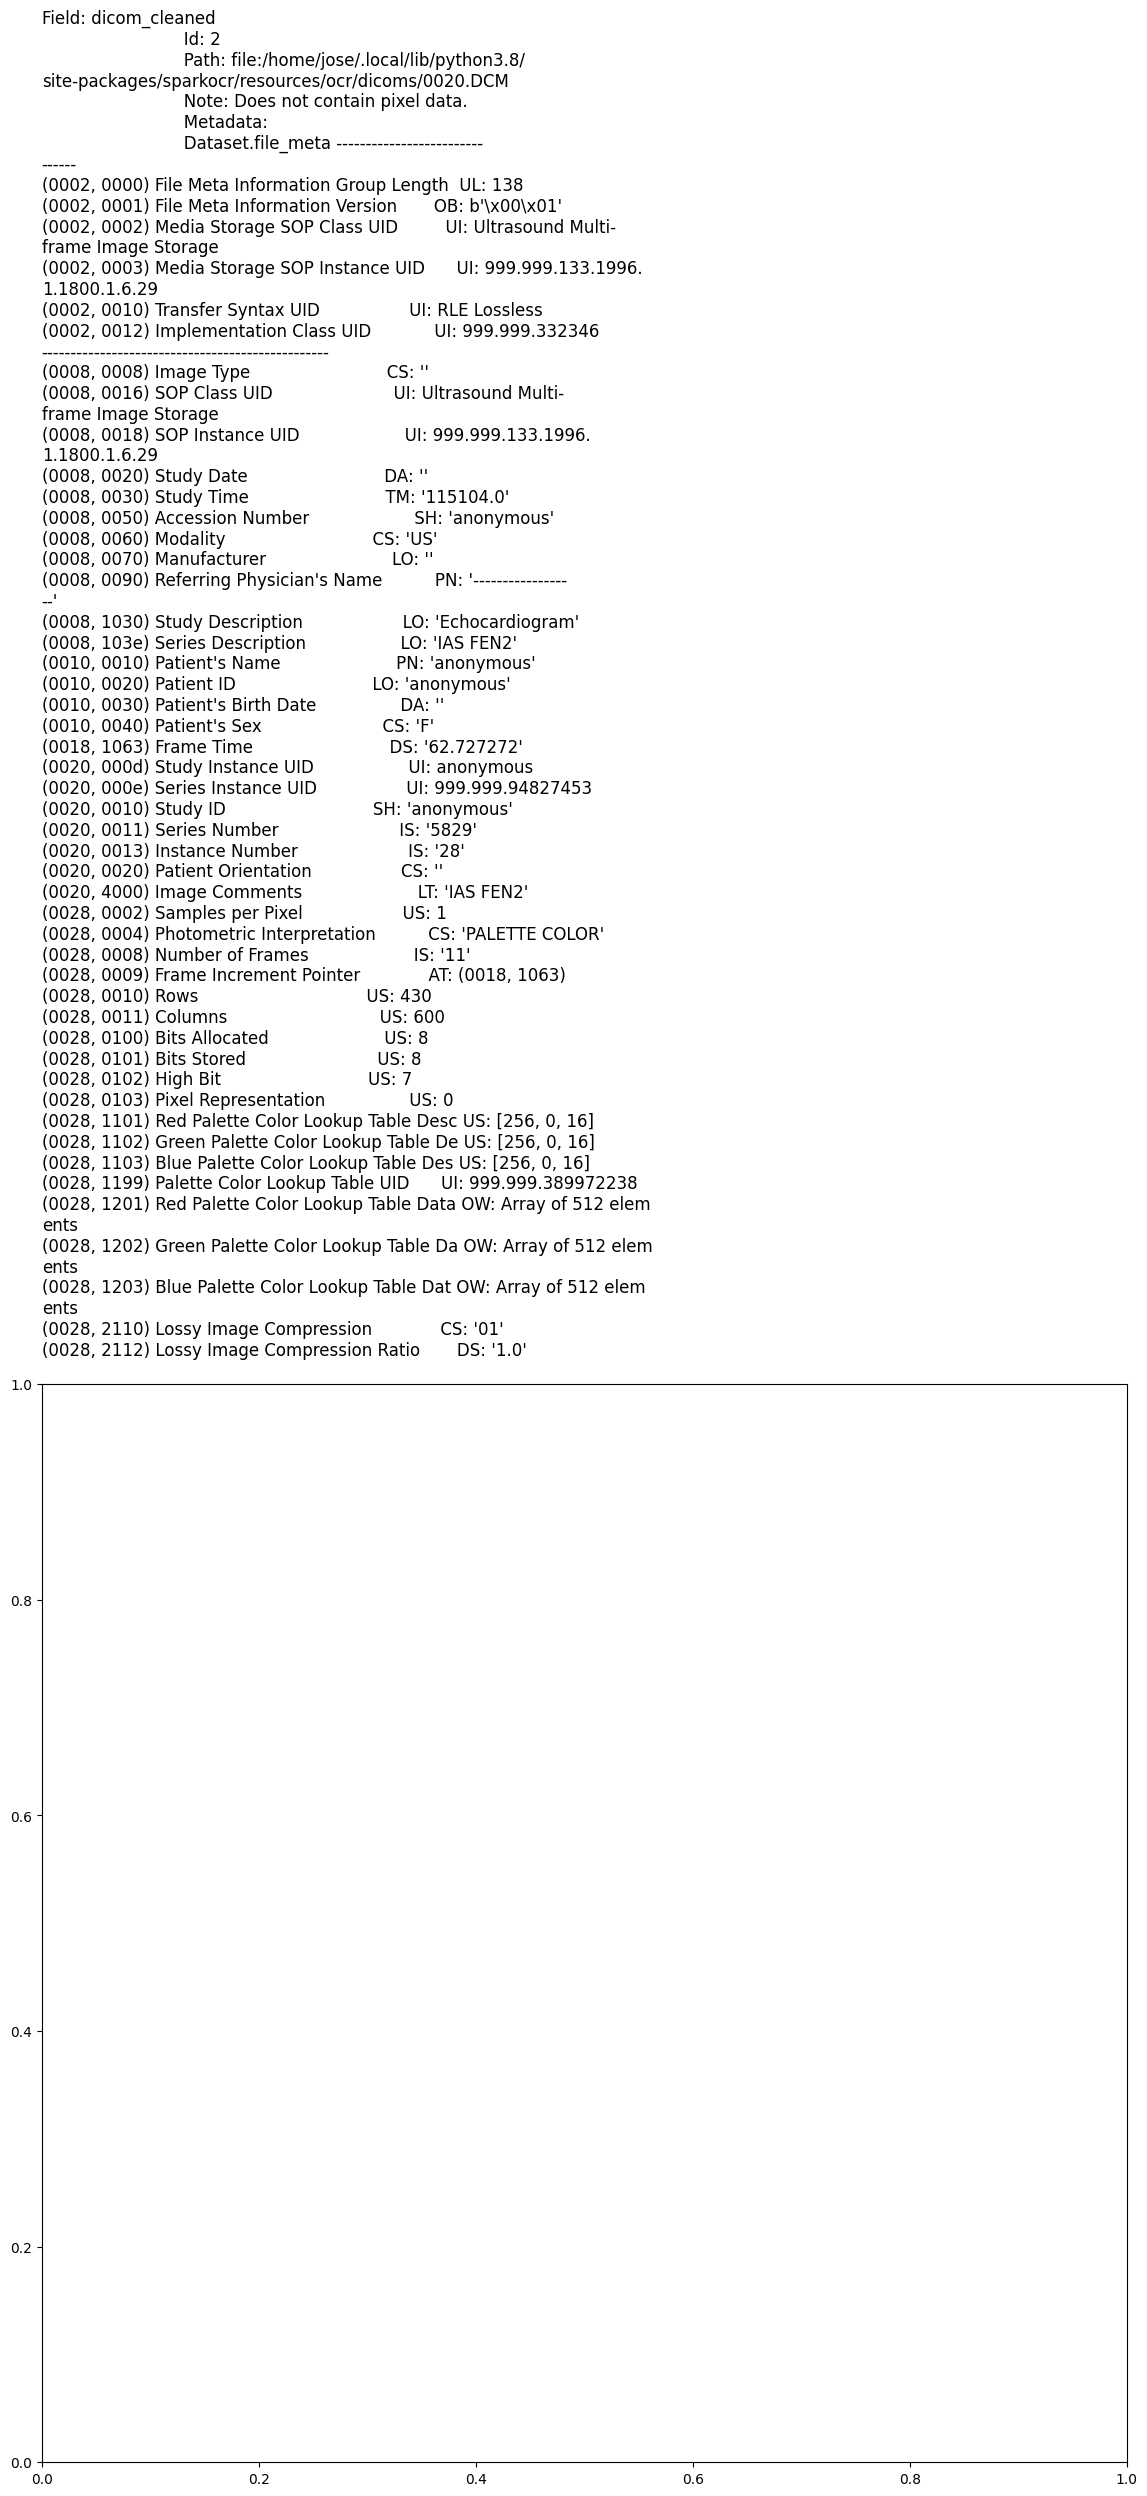

In [21]:
display_dicom(result, "dicom_cleaned")

## Pretrained Pipeline #2: `dicom_deid_full_anonymization`
This is the most aggressive version of the pipeline in which all texts in the images are removed together with most of the tags in the metadata.

In [12]:
pipeline = PretrainedPipeline("dicom_deid_full_anonymization", 'en', 'clinical/ocr')
result = pipeline.transform(dicom_df).cache()

dicom_deid_full_anonymization download started this may take some time.
Approx size to download 75.3 MB
[OK!]


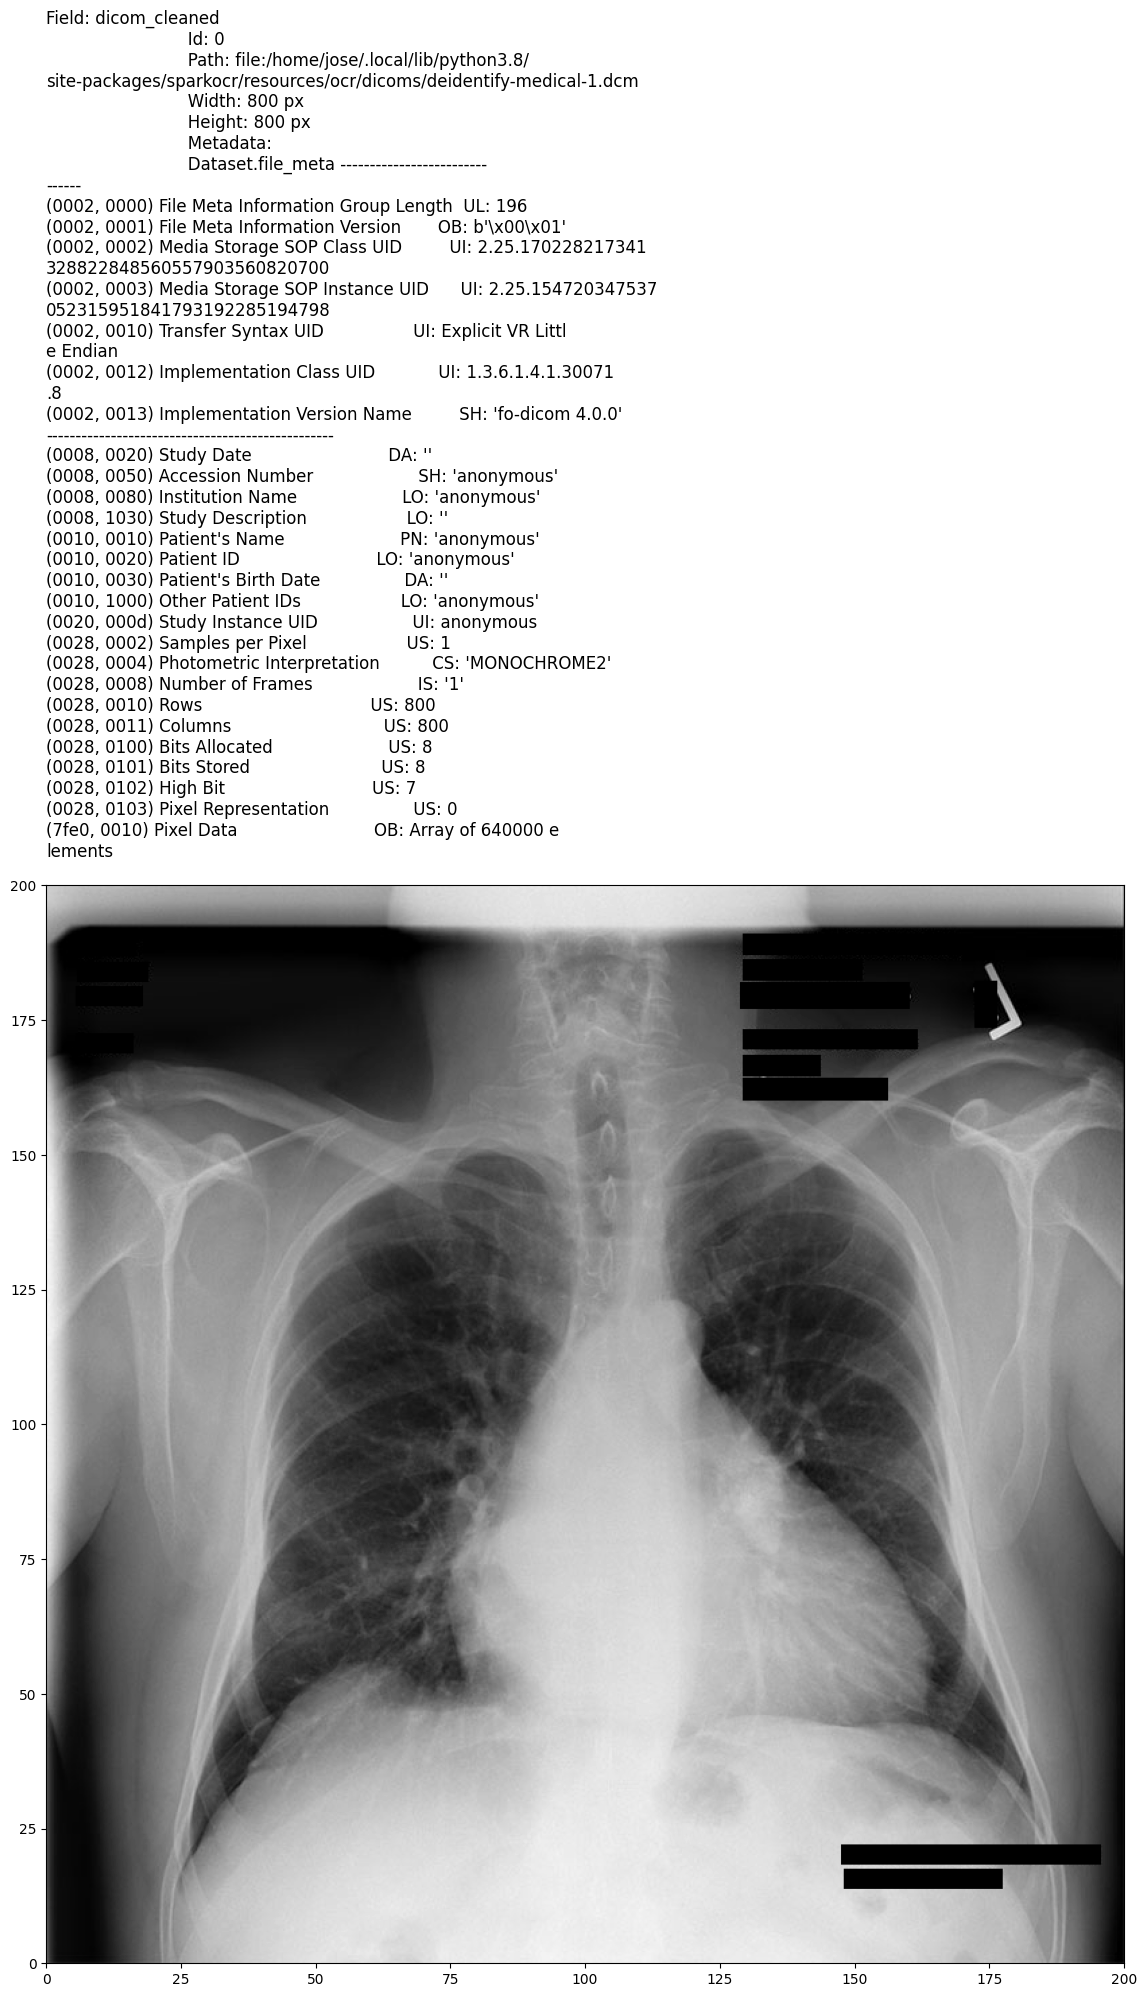

In [23]:
display_dicom(result, "dicom_cleaned")

## Pretrained Pipeline #3: `dicom_deid_generic_augmented_pseudonym`
This pipeline will attempt to replaces values in metadata with pseudonyms. Images will be de-identified for PHI.

In [13]:
pipeline = PretrainedPipeline("dicom_deid_generic_augmented_pseudonym", 'en', 'clinical/ocr')

dicom_deid_generic_augmented_pseudonym download started this may take some time.
Approx size to download 1.7 GB
[OK!]


/home/jose/.local/lib/python3.8/site-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


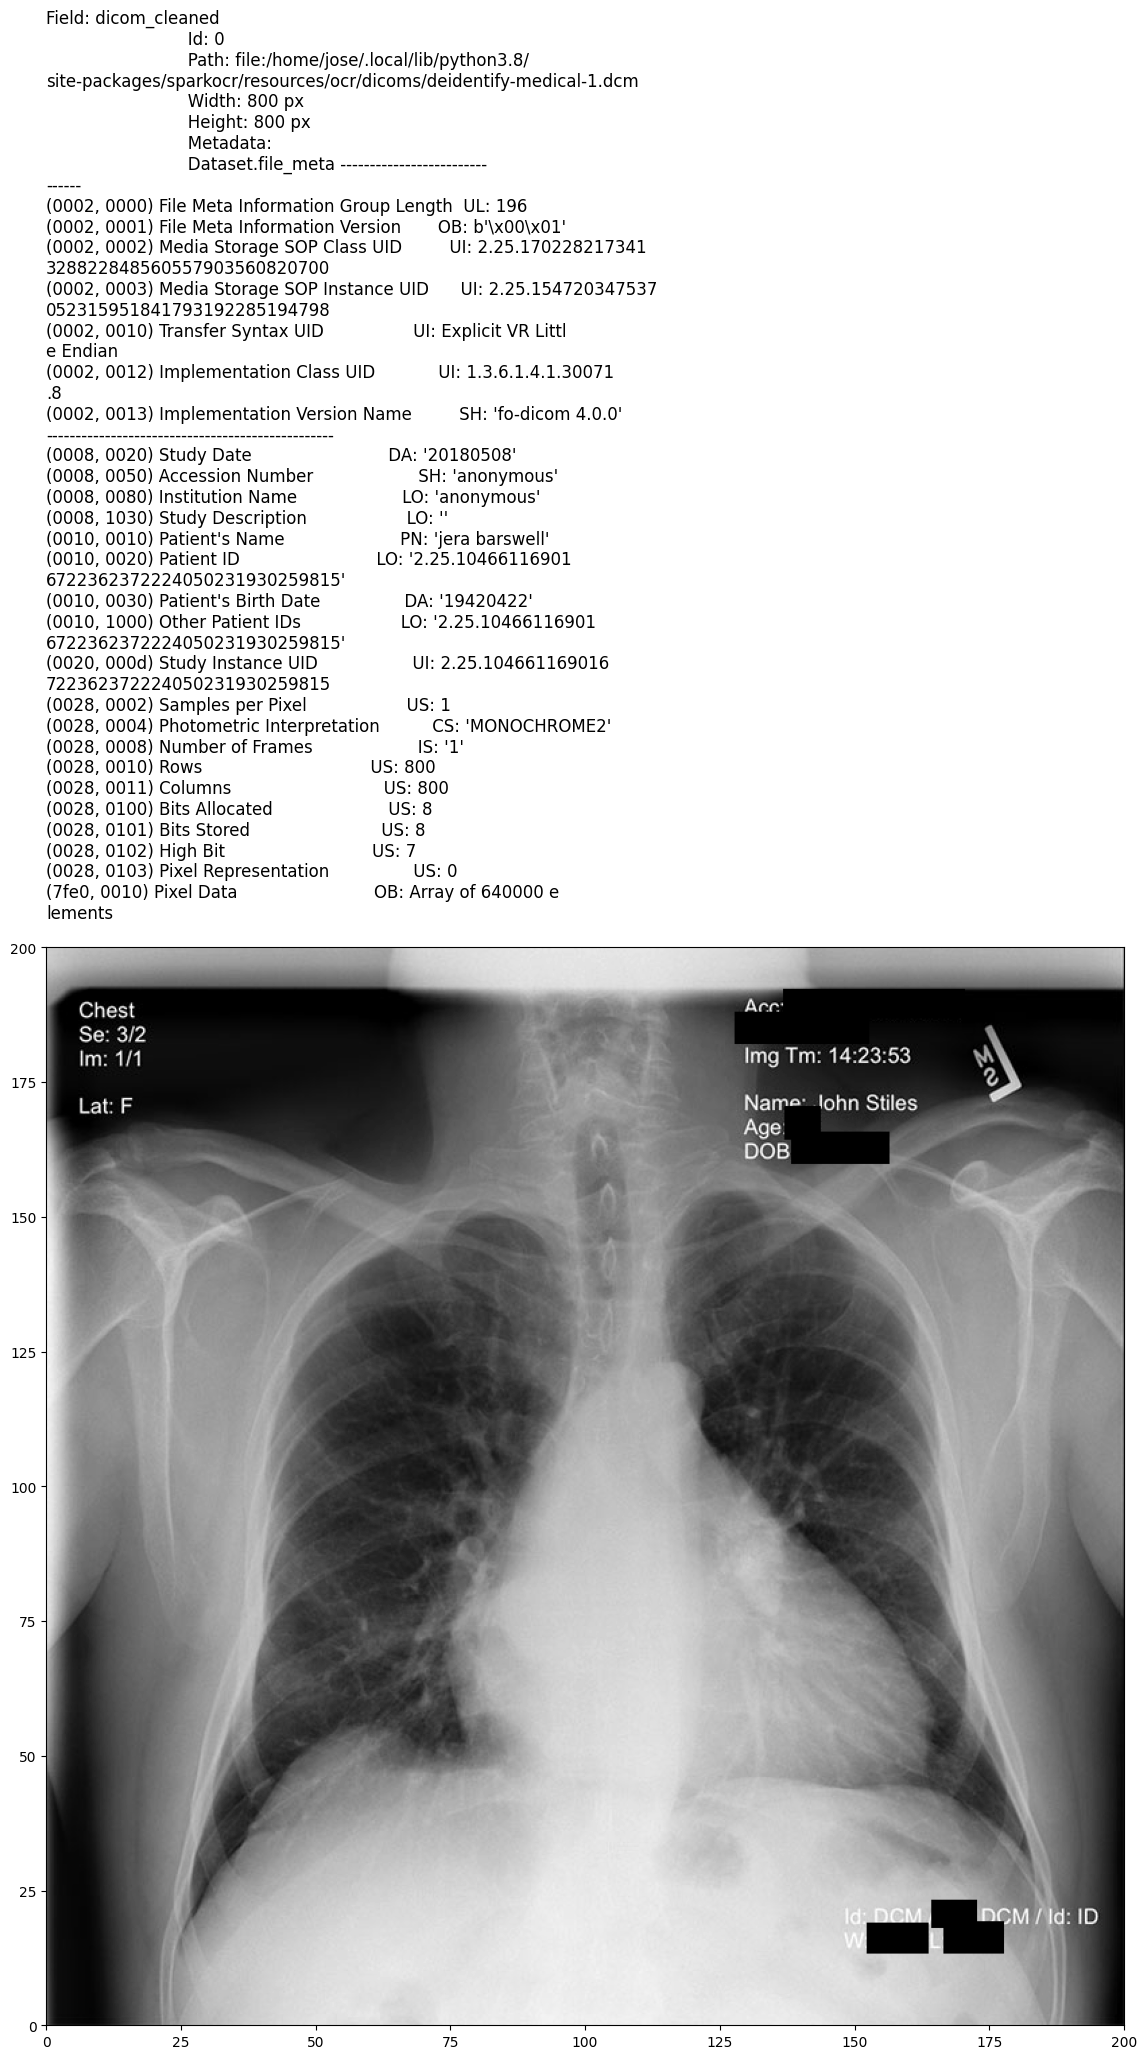

In [8]:
result = pipeline.transform(dicom_df).cache()
display_dicom(result, "dicom_cleaned")